#D

In [1]:
%load_ext autoreload
%autoreload 2

# Accumulated Local Effects for predicting house prices

In this example we will explain the behaviour of regression models on the Boston housing dataset. We will show how to calculate accumulated local effects (ALE) for determining the feature effects on the predictions and how these vary on different kinds of models (linear and non-linear models).

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers.ale import ALE, plot_ale

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Load and prepare the dataset

In [3]:
data = load_boston()
feature_names = data.feature_names
X = data.data
y = data.target

Shuffle the data and define the train and test set:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Fit and evaluate models

Fit and evaluate a linear regression model:

In [5]:
lr = LinearRegression(normalize=True)
#lr = Pipeline([('scaler', StandardScaler()),
#               ('model', LinearRegression())])

In [6]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [8]:
mean_squared_error(y_test, lr.predict(X_test))

22.098694827098008

Fit and evaluate a random forest model:

In [9]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [10]:
mean_squared_error(y_test, rf.predict(X_test))

10.429924314960628

## Calculate Accumulated Local Effects

Here we initialize the ALE explainer object by passing it the predictor function which in this case is the `clf.predict` method for both models. We also pass in feature names and target name for easier interpretation of the resulting explanations.

In [11]:
lr_ale = ALE(lr.predict, feature_names=feature_names, target_names=['Value in $1000\'s'])
rf_ale = ALE(rf.predict, feature_names=feature_names, target_names=['Value in $1000\'s'])

We now call the `explain` method on the explainer objects which will compute the ALE's and return an `Explanation` object which is ready for inspection and plotting. Since ALE is a global explanation method it takes in a batch of data for which the model feature effects are computed, in this case we pass in the training set.

In [12]:
lr_exp = lr_ale.explain(X_train)
rf_exp = rf_ale.explain(X_train)

The resulting `Explanation` objects contain the ALE's for each feature under the `ale_values` attribute - this is a list of numpy arrays, one for each feature. The easiest way to interpret the ALE values is by plotting them against the feature values for which we provide a built-in function `plot_ale`. By calling the function without arguments, we will plot the effects of every feature, so in this case we will get 13 different subplots. To fit them all on the screen we pass in options for the figure size.

## ALE for the linear regression model

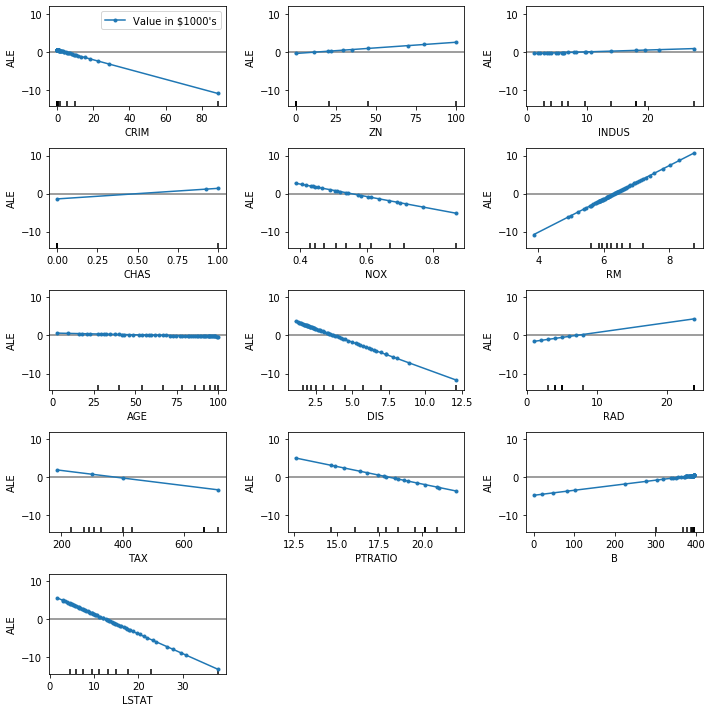

In [13]:
plot_ale(lr_exp, fig_kw={'figwidth':10, 'figheight': 10});

**TODO**: inferring feature importance from ALE plots is not straightforward, need to think about this more.

The interpretation of the ALE plot is that given a feature value, the ALE value corresponding to that feature value is difference to the mean prediction. Put differently, the ALE value is the relative feature effect on the prediction at that feature value.

Additionally, note that the ALE plots for different features are plotted on the same scale (`sharey='all'` is the default option), this allows to roughly determine the relative feature importances. For example, the range of the ALE values spanned by feature `RM` is higher than for any other feature, suggesting that the feature importance for `RM` is high. 

Let's look at the ALE plot for the feature `RM` (average number of rooms per dwelling) in more detail:

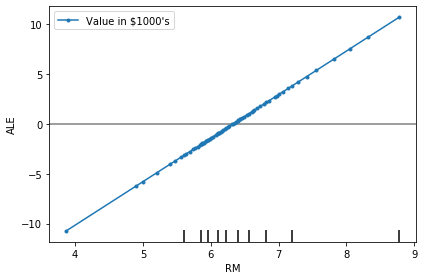

In [14]:
plot_ale(lr_exp, features=['RM']);

The ALE value for the point 8 is ~7.5 which has the interpretation that for properties for which the average number of rooms is ~8 the model predicts an up-lift of ~$7500 for the value of such properties with respect to the average prediction. On the other hand, for properties with an average number of rooms lower than ~6.25, the feature effect on the prediction becomes negative, i.e. a smaller number of rooms brings the predicted value down with respect to the average prediction.

Thus the ALE on the y-axes of these plots is in the units of the prediction variable which in this case is the value of the house in $1000's.


We now elaborate on the interpretation of the value of 0 on an ALE plot. As already mentioned, it corresponds the mean prediction:

In [15]:
lr.predict(X_train).mean()

22.907915567282295

Now, given that the ALE plot for the feature `RM` crosses the 0 value at around feature value ~6.25, we should expect that for instances with an average number of rooms in that region the model predicts the mean response again. We can check that explicitly by filtering for such values and making predictions:

In [16]:
subset = X_train[(X_train[:, 5] > 6.2) & (X_train[:, 5] < 6.3)]
print(subset.shape)

(19, 13)


In [17]:
lr.predict(subset).mean()

22.594245590200853

So in fact the mean prediction for instances with `RM`~6.25 is close to the mean prediction over all instances which is why the ALE value at ~6.25 is 0. This shows that ALE plots are centered such that the average effect over the data is 0.

An additional feature of the ALE plot is that it shows feature deciles on the x-axis. This is helpful to understand in which regions there is no data so the ALE plot is interpolating. For example, for the `CRIM` feature (per capita crime rate by town), there is very little to no data in the feature interval ~30-85, so the ALE plot in that region is just linearly interpolating:

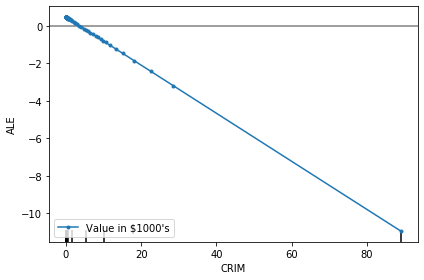

In [18]:
plot_ale(lr_exp, features=['CRIM']);

For linear models this is not an issue, however for non-linear models it can be dangerous to assume linear interpolation in feature areas with no data. This is why the use of deciles can help interpret in which areas of the feature space the feature effects can be safely interpreted. Additionally, by default the ALE plots feature discrete points which are the points where the ALE was calculated and straight lines which are the linear interpolation regions.

### Linearity of ALE

It is no surprise that the ALE plots for the linear regression model are linear themselves—the feature effects are after all linear by definition. In fact, the slopes of the ALE lines are exactly the coefficients of the linear regression:

In [19]:
lr.coef_

array([-1.28322638e-01,  2.95517751e-02,  4.88590934e-02,  2.77350326e+00,
       -1.62388292e+01,  4.36875476e+00, -9.24808158e-03, -1.40086668e+00,
        2.57761243e-01, -9.95694820e-03, -9.23122944e-01,  1.31854199e-02,
       -5.17639519e-01])

In [20]:
slopes = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(lr_exp.ale_values, lr_exp.feature_values)])

In [21]:
slopes

array([-1.28322638e-01,  2.95517751e-02,  4.88590934e-02,  2.77350326e+00,
       -1.62388292e+01,  4.36875476e+00, -9.24808158e-03, -1.40086668e+00,
        2.57761243e-01, -9.95694820e-03, -9.23122944e-01,  1.31854199e-02,
       -5.17639519e-01])

Thus the slopes of the ALE plots for linear regression have exactly the same interpretation as the coefficients of the learnt model—global feature effects.

## ALE for the random forest model

Now let's look at the ALE plots for the non-linear random forest model:

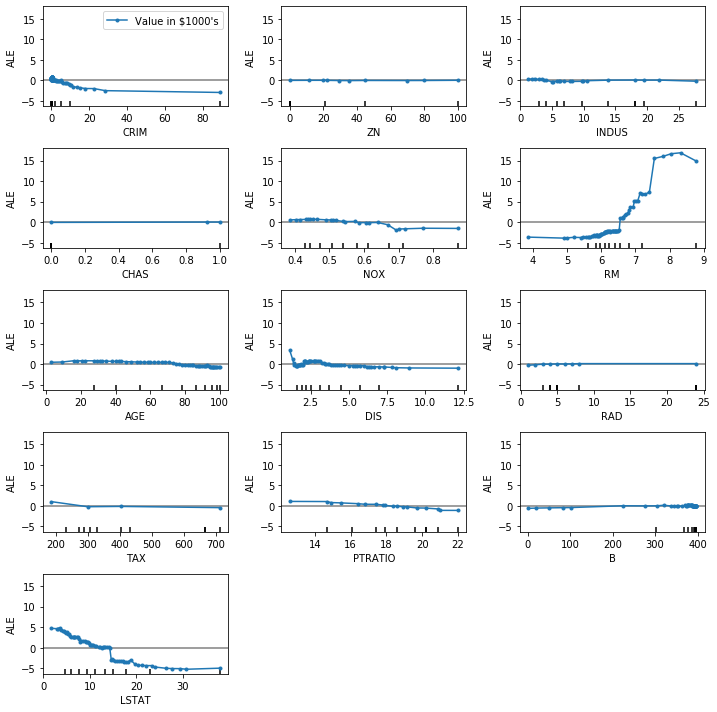

In [22]:
axes = plot_ale(rf_exp, fig_kw={'figwidth':10, 'figheight': 10});

Because the model is no longer linear, the ALE plots are non-linear also and in some cases also non-monotonic. The interpretation of the plots is still the same - the ALE value at a point is the relative feature effect with respect to the mean prediction, however the non-linear model used shows that the feature effects differ both in shape and magnitude.

From these plots it seems that the feature `RM` has the biggest impact on the prediction. Checking the feature importances of the random forest classifier confirms this:

In [26]:
feature_names[rf.feature_importances_.argmax()]

'RM'

Let's explore the feature `DIS` (weighted distances to five Boston employment centres) and how its effects are different between the two models. To do this we can pass in matplotlib `axes` objects for the `plot_ale` function to plot on:

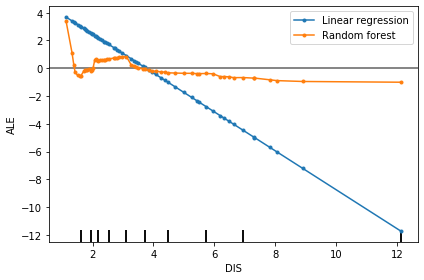

In [23]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['DIS'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['DIS'], ax=ax, line_kw={'label': 'Random forest'});

From this plot we can gather several interesting insights:

 - Linear regression puts a higher emphasis on the `DIS` feature as evidenced by the relative magnitudes of the ALE scores across the feature range.
 - Whilst the linear regression feature effects of `DIS` are negatively correlated (the higher the distance to employment centres, the lower the predicted value), the random forest feature effects are not monotonic.
 - In particular, at the start of the range of `DIS` there seems to be switching between positive and negative effects.

To compare multiple models and multiple features we can plot the ALE's on a common axis that is big enough to accommodate all features of interest:

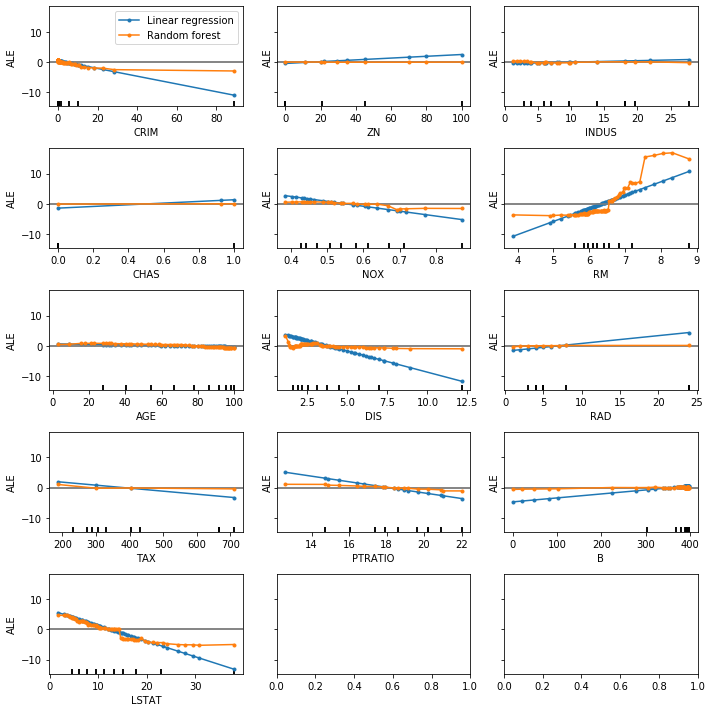

In [24]:
fig, ax = plt.subplots(5, 3, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':10, 'figheight': 10},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random forest'});